# Cleaning and EDA of Coffee Businesses in the Yelp Academic Dataset 

In this notebook I focused on exploring and cleaning the business data file in the Yelp Academic dataset. I wanted to focus on what other categories contributed to a high star rating (>= 4.0 stars) for coffee related businesses. Hypothesize that businesses associating with other categories apart from coffee related ones are more likely to have higher star ratings. 

In [53]:
import pandas as pd
from pandasql import sqldf

In [1]:
business_df = pd.read_json('C:\\Users\\shull\\Downloads\\yelp_dataset\\yelp_dataset\\yelp_academic_dataset_business.json', lines=True)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [2]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


## Dropping unrelated columns and checking for nulls

In [3]:
# Mainly want to observe the city, state, stars, review_count, and categories columns. Remove the other columns.
biz_df = business_df.drop(business_df.columns[[2, 5, 6, 7, 10, 11, 13]], axis=1)

biz_df.head()

,business_id,name,city,state,stars,review_count,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,5.0,7,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,3.0,15,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,3.5,22,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,4.5,13,"Brewpubs, Breweries, Food"


In [4]:
# Checking for nulls
biz_df.isna().any()

business_id     False
name            False
city            False
state           False
stars           False
review_count    False
categories       True
dtype: bool

In [5]:
# Drop rows with nulls
biz_df = biz_df.dropna()
biz_df.isna().any()

business_id     False
name            False
city            False
state           False
stars           False
review_count    False
categories      False
dtype: bool

In [6]:
# Number of rows
len(biz_df.index)

150243

## Reformatting the `categories` column

`categories` column originally had one string values. One-hot encoded the categories so it is easier to parse. This will help us identify which businesses serve coffee and other categories associated with it.

In [7]:
biz_df['categories'] = biz_df['categories'].str.split(', ', expand=False)

biz_df['categories_clean'] = list(map(lambda x: '|'.join(x), biz_df['categories']))
categories_df = biz_df.categories_clean.str.get_dummies(sep='|')

# merge
biz_df = biz_df.merge(categories_df, left_index=True, right_index=True)

# remove intermediate columns (no longer needed)
biz_df.drop(['categories', 'categories_clean'], axis=1, inplace=True)
biz_df.head()

,business_id,name,city,state,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,5.0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,3.0,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,3.5,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,4.5,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
list(biz_df.columns)

['business_id',
 'name',
 'city',
 'state',
 'stars',
 'review_count',
 '& Probates',
 '3D Printing',
 'ATV Rentals/Tours',
 'Acai Bowls',
 'Accessories',
 'Accountants',
 'Acne Treatment',
 'Active Life',
 'Acupuncture',
 'Addiction Medicine',
 'Adoption Services',
 'Adult',
 'Adult Education',
 'Adult Entertainment',
 'Advertising',
 'Aerial Fitness',
 'Aerial Tours',
 'Aestheticians',
 'Afghan',
 'African',
 'Air Duct Cleaning',
 'Aircraft Dealers',
 'Aircraft Repairs',
 'Airlines',
 'Airport Lounges',
 'Airport Shuttles',
 'Airport Terminals',
 'Airports',
 'Airsoft',
 'Allergists',
 'Alternative Medicine',
 'Amateur Sports Teams',
 'American (New)',
 'American (Traditional)',
 'Amusement Parks',
 'Anesthesiologists',
 'Animal Assisted Therapy',
 'Animal Physical Therapy',
 'Animal Shelters',
 'Antiques',
 'Apartment Agents',
 'Apartments',
 'Appliances',
 'Appliances & Repair',
 'Appraisal Services',
 'Aquarium Services',
 'Aquariums',
 'Arabic',
 'Arcades',
 'Archery',
 'Architec

In [9]:
# 'Food' is the main category while the others are subcategories under it.
# See that the relevant subcategories include 'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries', 'Coffeeshops'

query = """
        SELECT *
        FROM biz_df
        WHERE
            `Coffee & Tea` = 1 OR
            `Coffee & Tea Supplies` = 1 OR
            `Coffee Roasteries` = 1 OR
            `Coffeeshops` = 1
        """
coffee_biz_df = sqldf(query)

coffee_biz_df.head()

,business_id,name,city,state,stars,review_count,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,Edmonton,AB,4.0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JX4tUpd09YFchLBuI43lGw,Naked Cyber Cafe & Espresso Bar,Edmonton,AB,4.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,Nashville,TN,3.5,159,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cVBxfMC4lp3DnocjYA3FHQ,Paws The Cat Cafe,Edmonton,AB,5.0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
coffee_biz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6728 entries, 0 to 6727
Columns: 1317 entries, business_id to Zoos
dtypes: float64(1), int64(1312), object(4)
memory usage: 67.6+ MB


## Exploring Star Ratings of Coffee related Businesses

In [11]:
print('Lowest rating: ' + coffee_biz_df['stars'].min().astype('str'))
print('Highest rating: ' + coffee_biz_df['stars'].max().astype('str'))

Lowest rating: 1.0
Highest rating: 5.0


<AxesSubplot: >

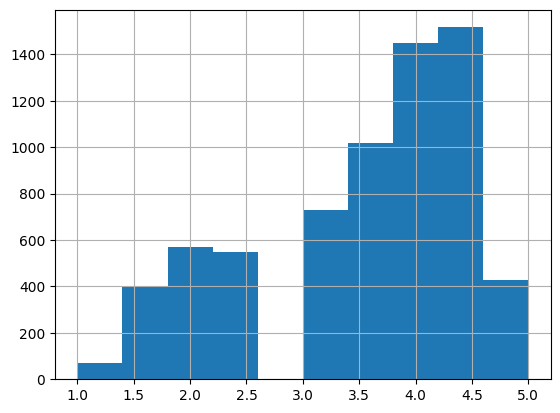

In [12]:
# Star rating histogram 
coffee_biz_df['stars'].hist()

From the histogram we can see that most businesses that are coffee related have a 4.5 or 4.0 star rating on Yelp.

# Descriptive Statistics
In this section I conduct some descriptive statistics and additional exploration of the data.

In [17]:
# Further cleaning: drop columns that have only the value 0

coffee_biz_df = coffee_biz_df.loc[:, coffee_biz_df.any()]
coffee_biz_df.head()

,business_id,name,city,state,stars,review_count,Acai Bowls,Accessories,Active Life,Adult,...,Wholesale Stores,Wholesalers,Wine & Spirits,Wine Bars,Wine Tasting Room,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,Edmonton,AB,4.0,40,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,JX4tUpd09YFchLBuI43lGw,Naked Cyber Cafe & Espresso Bar,Edmonton,AB,4.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,Nashville,TN,3.5,159,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,cVBxfMC4lp3DnocjYA3FHQ,Paws The Cat Cafe,Edmonton,AB,5.0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Created new column 'categories_sum' to find total number of categories associated with a business.

coffee_biz_df['categories_sum'] = coffee_biz_df.iloc[:, 6:].sum(axis = 1)
coffee_biz_df.head()

,business_id,name,city,state,stars,review_count,Acai Bowls,Accessories,Active Life,Adult,...,Wholesalers,Wine & Spirits,Wine Bars,Wine Tasting Room,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga,categories_sum
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,Edmonton,AB,4.0,40,0,0,0,0,...,0,0,1,0,0,0,0,0,0,7
2,JX4tUpd09YFchLBuI43lGw,Naked Cyber Cafe & Espresso Bar,Edmonton,AB,4.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,Nashville,TN,3.5,159,0,0,0,0,...,0,0,1,0,0,0,0,0,0,12
4,cVBxfMC4lp3DnocjYA3FHQ,Paws The Cat Cafe,Edmonton,AB,5.0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [50]:
coffee_biz_df['categories_sum'].describe()

count    6728.000000
mean        5.086207
std         2.418648
min         2.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        36.000000
Name: categories_sum, dtype: float64

In [30]:
coffee_biz_df['stars'].describe()

count    6728.000000
mean        3.521254
std         1.011856
min         1.000000
25%         3.000000
50%         4.000000
75%         4.500000
max         5.000000
Name: stars, dtype: float64

In [31]:
coffee_biz_df['review_count'].describe()

count    6728.000000
mean       63.990042
std       147.840137
min         5.000000
25%        11.000000
50%        25.000000
75%        59.000000
max      5721.000000
Name: review_count, dtype: float64

In [49]:
# Observing cities with the highest average ratings and highest average of reviews

sqldf("""
    SELECT
        `state`, 
        AVG(`stars`) AS `stars_mean`,
        AVG(`review_count`) AS `review_mean`, 
        AVG(`categories_sum`) AS `category_count_mean`
    FROM coffee_biz_df
    GROUP BY `state`
    ORDER BY `stars_mean` DESC, `review_mean` DESC, `category_count_mean` DESC
""").head(10)

,state,stars_mean,review_mean,category_count_mean
0,ID,3.854839,43.976959,4.585253
1,CA,3.772973,132.702703,5.367568
2,LA,3.665612,113.459916,5.067511
3,NV,3.570632,86.026022,4.944238
4,TN,3.557460,75.782258,5.262097
5,AB,3.550000,21.634211,4.665789
6,IN,3.543710,63.102345,4.874200
7,MO,3.543326,71.569087,5.374707
8,FL,3.537287,59.078167,5.372866
9,AZ,3.495739,63.596591,4.488636


The descriptive statistics performed show that that state of Idaho has the highest star ratings (~3.85). The mean of all businesses' star ratings is ~3.5 and the mean of number of categories of businesses is ~5.0. Coffee businesses have about an average of ~64.0 reviews, though the `review_count` data is somewhat spread out according to its relatively higher standard deviation (147.8). It's likely that its mean is influenced by some outliers.

In [59]:
stars_df = sqldf("""
    SELECT
        `stars`,
        AVG(`review_count`) AS `review_mean`, 
        AVG(`categories_sum`) AS `category_count_mean`
    FROM coffee_biz_df
    GROUP BY `stars`
""")

stars_df

,stars,review_mean,category_count_mean
0,1.0,20.000000,4.450704
1,1.5,26.391960,4.683417
2,2.0,22.500879,4.393673
3,2.5,25.647273,4.272727
4,3.0,32.642857,4.447802
5,3.5,54.933137,4.800393
6,4.0,103.504138,5.519310
7,4.5,96.839156,5.777851
8,5.0,35.221963,5.378505


<AxesSubplot: xlabel='stars', ylabel='mean number of reviews'>

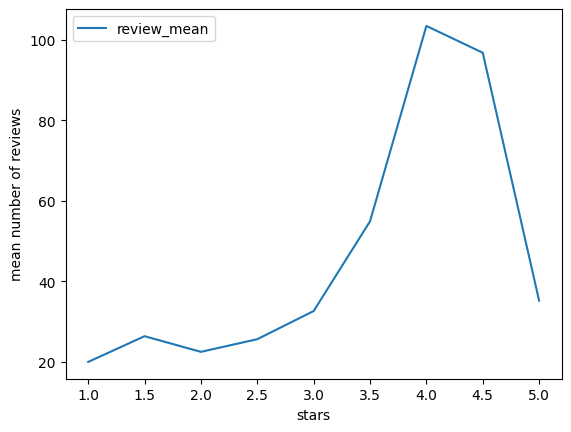

In [64]:
stars_df.plot('stars', 'review_mean', ylabel='mean number of reviews')

<AxesSubplot: xlabel='stars', ylabel='mean number of categories'>

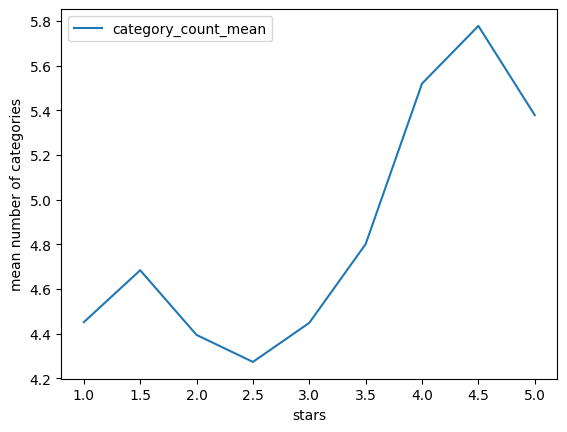

In [65]:
stars_df.plot('stars', 'category_count_mean', ylabel='mean number of categories')

Based upon the plots, it appears that as higher rated businesses have higher number of categories, including the `Food` and `Coffee & Tea` categories. It's strange that the highest rated businesses do not necessarily have more reviews than businesses that are rated slightly lower. Perhaps this is due to location or outliers.